In [16]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import matplotlib
from sobol_seq import i4_sobol
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from msfm.utils import files, parameters, input_output
from msfm.grid_pipeline import GridPipeline
from msfm.utils.cosmogrid import get_cosmo_params_info

n_side = 512
n_pix = hp.nside2npix(n_side)

### CosmoGrid params

In [2]:
cosmo_params_info = get_cosmo_params_info("../../data/CosmoGridV1_metainfo.h5")
print(cosmo_params_info.dtype)

all_Om = cosmo_params_info["Om"]
all_s8 = cosmo_params_info["s8"]
all_w0 = cosmo_params_info["w0"]
all_sobol = cosmo_params_info["sobol_index"]

[('As', '<f8'), ('bary_Mc', '<f8'), ('bary_nu', '<f8'), ('H0', '<f8'), ('O_cdm', '<f8'), ('O_nu', '<f8'), ('Ob', '<f8'), ('Ol', '<f8'), ('Om', '<f8'), ('m_nu', '<f8'), ('ns', '<f8'), ('s8', '<f8'), ('w0', '<f8'), ('wa', '<f8'), ('delta', 'S128'), ('sobol_index', '<i4'), ('benchmark_type', 'S128'), ('id_param', '<i4'), ('path_par', 'S128'), ('box_size_Mpc_over_h', '<f8'), ('n_particles', '<i8'), ('n_shells', '<i4'), ('n_steps', '<i4')]


### Extended params

In [3]:
conf = files.load_config()
sobol_priors = parameters.get_prior_intervals(
    conf["analysis"]["params"]["sobol"] + conf["analysis"]["params"]["ia"] + conf["analysis"]["params"]["bg"]
)

all_bg = []
all_n_bg = []
for i_sobol in all_sobol:
    sobol_point, _ = i4_sobol(sobol_priors.shape[0], i_sobol)
    sobol_params = sobol_point * np.squeeze(np.diff(sobol_priors)) + sobol_priors[:, 0]
    sobol_params = sobol_params.astype(np.float32)

    Aia = sobol_params[6]
    n_Aia = sobol_params[7]
    bg = sobol_params[8]
    n_bg = sobol_params[9]

    all_bg.append(bg)
    all_n_bg.append(n_bg)

# $\sigma_8 - b_g$ degeneracy

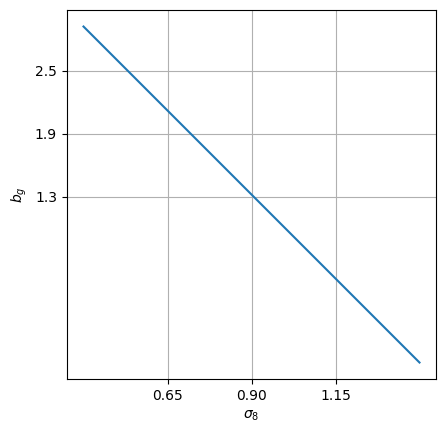

In [4]:
# b_g = -3.2 sigma_8 + 4.2
s8_prior = np.squeeze(parameters.get_prior_intervals(["s8"]))
x = np.linspace(s8_prior[0], s8_prior[1], 50)


fig, ax = plt.subplots()
ax.plot(x, -3.2*x + 4.2)
ax.set_xticks([0.65, 0.9, 1.15])
ax.set_yticks([1.3, 1.9, 2.5])
ax.set_box_aspect(1)
ax.set(xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
ax.grid(True)

In [5]:
assert len(all_Om) == len(all_s8) == len(all_w0) == len(all_bg) == len(all_n_bg)

# degenerate cosmos in the sigma_8, b_g plane
deg_sobol = []
for i, (sobol, Om, s8, w0, bg, n_bg) in enumerate(zip(all_sobol, all_Om, all_s8, all_w0, all_bg, all_n_bg)):
    
    # sigma_8 - b_g degeneracy plane 
    if np.abs(-3.2 * s8 + 4.2 - bg) <= 0.2:

        # Omega_m, w0 and n_bg
        if np.abs(Om - 0.25) <= 0.05 and np.abs(w0 + 1.0) <= 0.3 and np.abs(n_bg - 0.5) <= 0.5:
            deg_sobol.append(sobol)
            
print(len(deg_sobol))
print(deg_sobol)

21
[20, 451, 835, 996, 1500, 3068, 3179, 6124, 23508, 32276, 37571, 70668, 84100, 111364, 122139, 147227, 148451, 177147, 181964, 189395, 198996]


# plots

### loop through all of the grid data

In [6]:
pipeline_kwargs = {
    "with_lensing": False,
    "with_clustering": True,
    "apply_norm": False,
    "with_padding": True,
}
grid_pipe = GridPipeline(**pipeline_kwargs)
data_vec_pix = grid_pipe.data_vec_pix

23-08-29 14:25:41     files.py INF   Loaded the pixel file /cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-08-29 14:25:41     files.py INF   Loaded the pixel file /cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


2023-08-29 14:25:42.264055: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
dset_kwargs = {
    "i_noise" : 0,
    "local_batch_size": "cosmo",
    # bad for performance, but ensures there's only a single cosmology per batch
    "n_readers": 1,
    "n_prefetch": 1,
}
grid_dset = grid_pipe.get_dset(tfr_pattern="/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v4/large_scales/tfrecords/DESy3_grid_???.tfrecord", **dset_kwargs)

23-08-29 14:25:42 grid_pipelin INF   Interleaving with n_readers = 1 
23-08-29 14:25:42 grid_pipelin INF   The dset is batched by cosmology 
23-08-29 14:25:42 grid_pipelin INF   Batching into 16 elements locally 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-08-29 14:25:43 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-08-29 14:25:45 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'dg']) 
23-08-29 14:25:45 grid_pipelin INF   Prefetching 1 elements 
23-08-29 14:25:45 grid_pipelin INF   Successfully generated the grid set with element_spec (TensorSpec(shape=(None, 464896, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))) for i_noise = 0 


In [14]:
# %%time
# data_vectors = []
# cosmos = []
# for data_vector, cosmo, index in tqdm(grid_dset, total=2500):
#     if index[0][0] in deg_sobol:
#         data_vectors.append(data_vector)
#         cosmos.append(cosmo)
        
#         print(f"{len(data_vectors)}/{len(deg_sobol)}: {index[0][0]}")

In [15]:
# with h5py.File("./s8_bg_degeneracy_raw.h5", "w") as f:
#     f.create_dataset(name="data_vectors", data=data_vectors)
#     f.create_dataset(name="cosmos", data=cosmos)
#     f.create_dataset(name="sobol", data=deg_sobol)


### load the selected cosmologies

In [22]:
with h5py.File("./s8_bg_degeneracy_raw.h5", "r") as f:
    data_vectors = f["data_vectors"][:]
    cosmos = f["cosmos"][:]

# shapes
n_cosmos = data_vectors.shape[0]
n_examples = data_vectors.shape[1]
n_tomo = data_vectors.shape[3]
print(data_vectors.shape)

cosmos = cosmos[:,0]
print(cosmos.shape)

# sort by sigma_8
i_sort = np.argsort(cosmos[:,1])
data_vectors = data_vectors[i_sort]
cosmos = cosmos[i_sort]

(21, 16, 464896, 4)
(21, 10)


In [29]:
cosmos[0]

array([ 2.8749999e-01,  4.9375001e-01,  6.9062500e+01,  4.4062499e-02,
        1.0012500e+00, -8.0184376e-01,  9.3750000e-01,  6.8750000e-01,
        2.7937500e+00,  1.8750000e-01], dtype=float32)

In [30]:
np.mean(data_vectors, axis=(1,2)).shape

(21, 4)

[-0.01354016 -0.01418751 -0.01217705 -0.01593515 -0.01129077 -0.01263935
 -0.01454866 -0.01468903 -0.01539452 -0.01572941 -0.01379207 -0.0131337
 -0.01608437 -0.01257336 -0.01343864 -0.01401972 -0.01342286 -0.01155677
 -0.01180486 -0.01378212 -0.01316312]
[-0.0056793  -0.00378832 -0.00473165 -0.00670061 -0.00456943 -0.00466465
 -0.00475489 -0.00545462 -0.00437843 -0.00422376 -0.00565581 -0.00545296
 -0.00425058 -0.00412263 -0.00525639 -0.00561111 -0.00510213 -0.00433947
 -0.0048933  -0.00505331 -0.00502686]
[-0.00681828 -0.00650985 -0.00584387 -0.00626263 -0.00501534 -0.00484804
 -0.00627719 -0.00687158 -0.00531287 -0.00568686 -0.00598039 -0.00631776
 -0.00573829 -0.00652754 -0.00426536 -0.005819   -0.0053492  -0.00474682
 -0.00521928 -0.00551577 -0.00513101]
[-2.8655745e-04 -1.4529822e-03 -1.5392364e-03  3.6638539e-05
 -4.5091941e-04 -4.6730755e-04 -2.6329112e-04 -1.5926606e-03
 -5.1495840e-04 -3.3124890e-03 -2.4681045e-03 -7.8446063e-04
 -1.9155772e-03 -1.6047655e-03 -5.4630032e-04 -

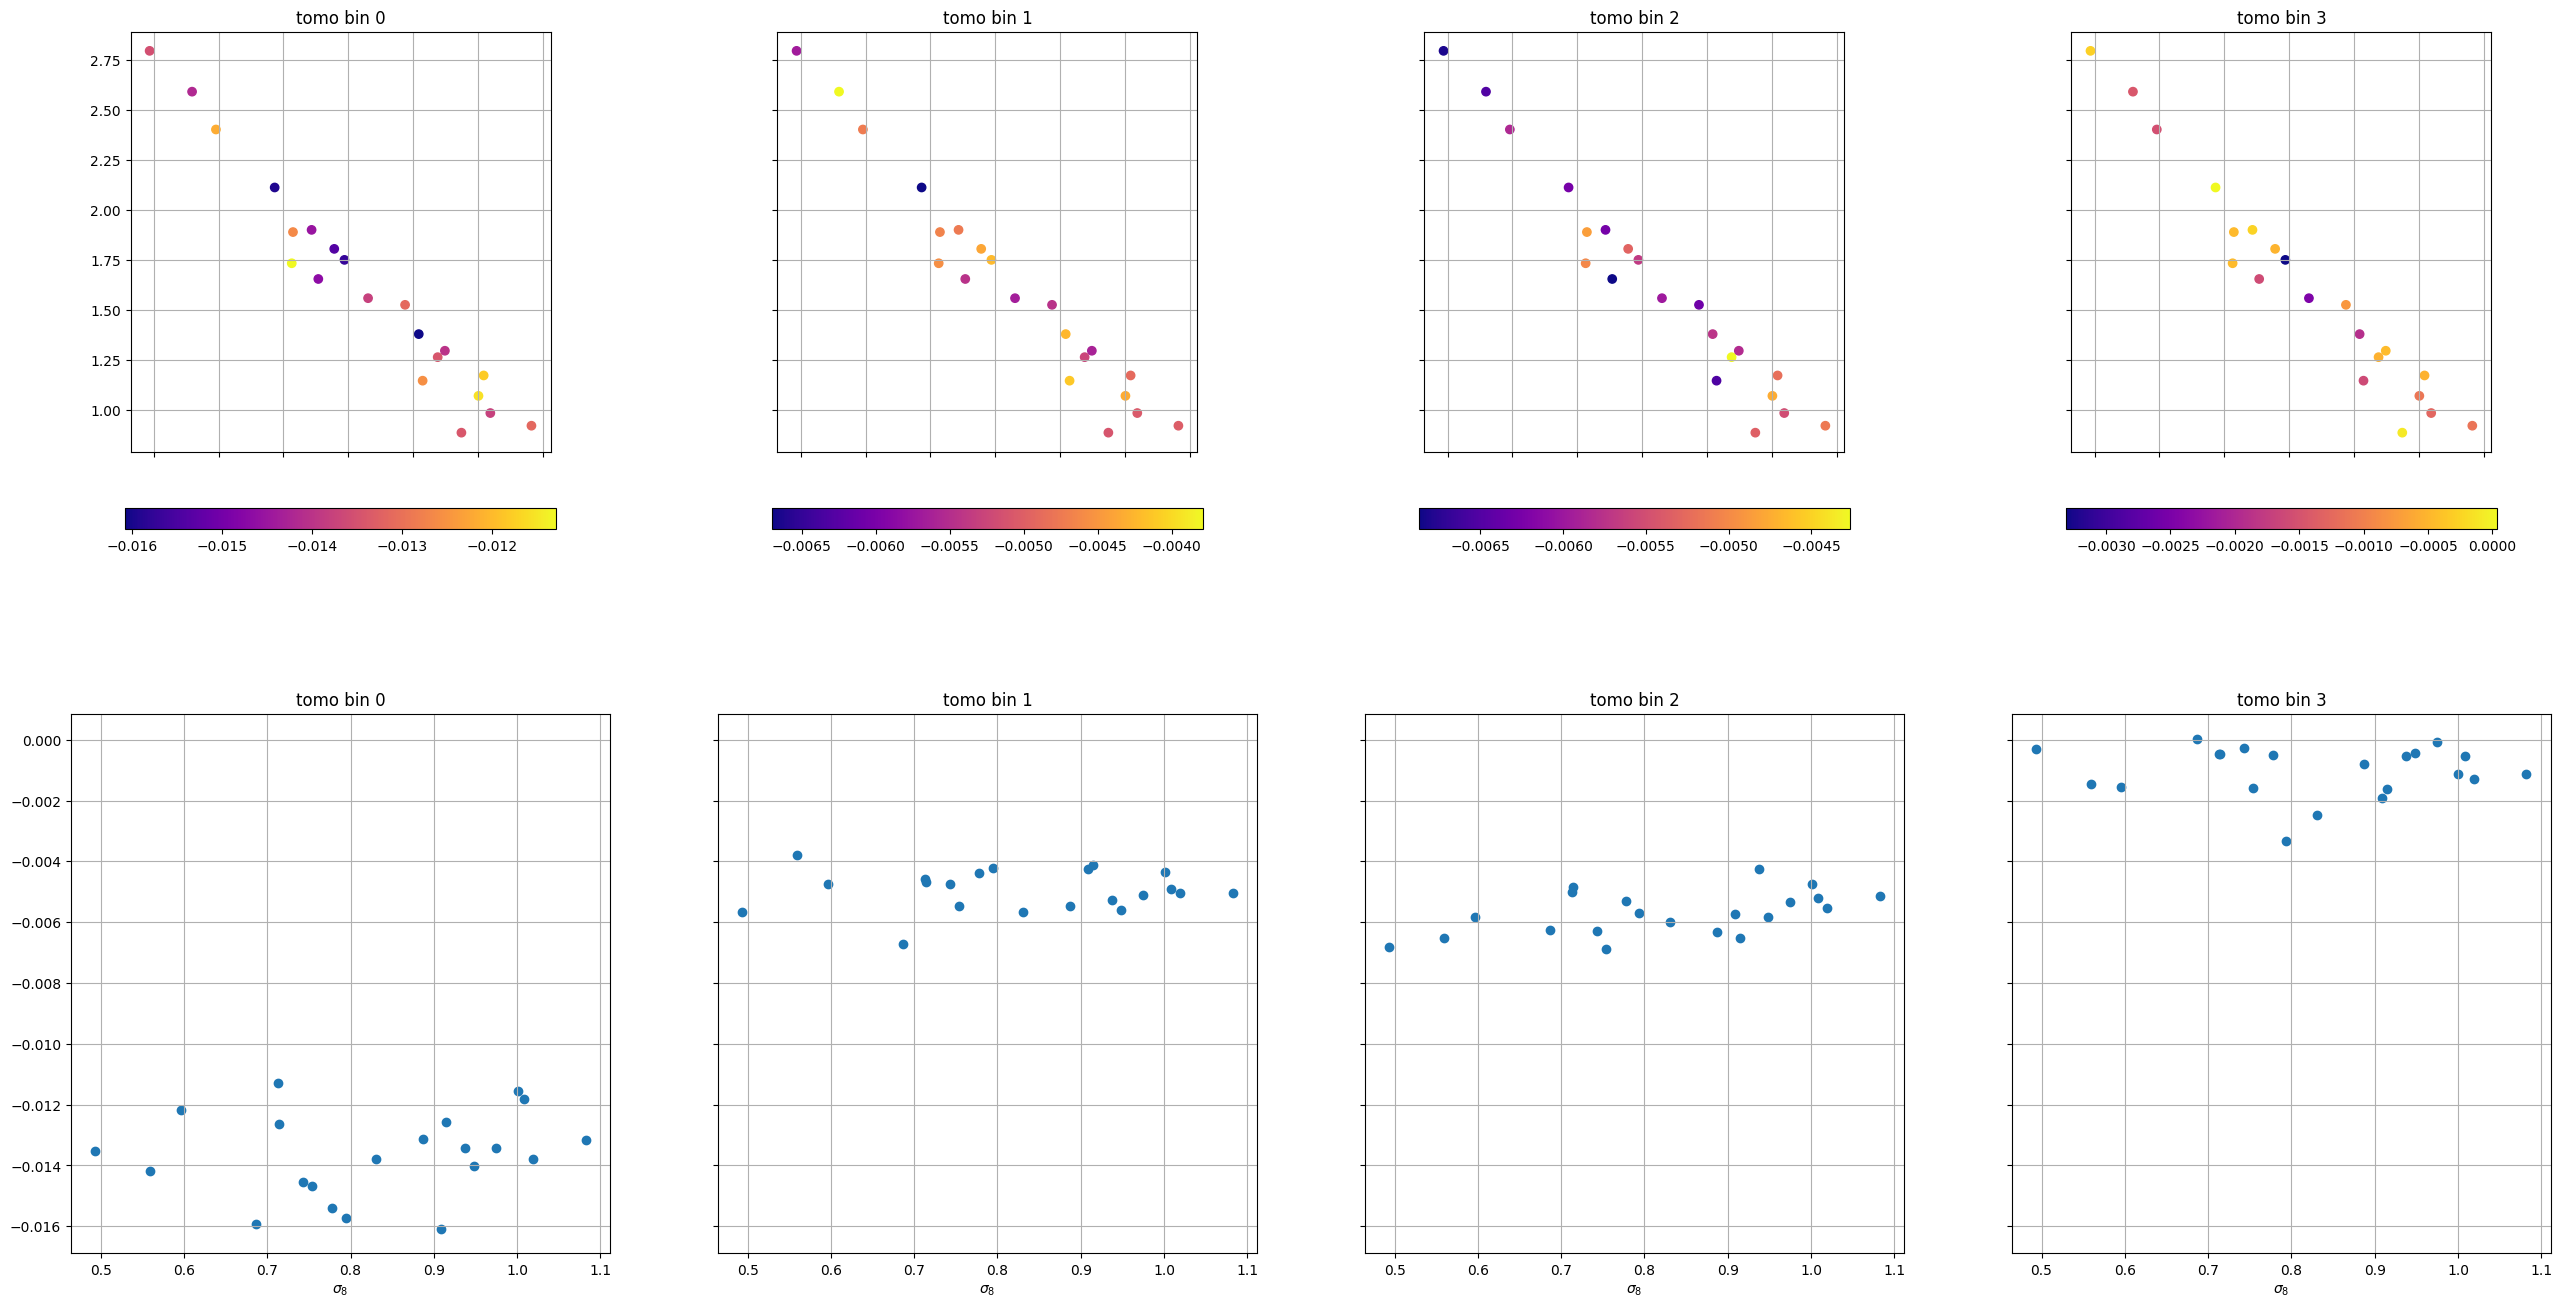

In [52]:
pix_stats = []

pix_stats.append(np.mean(data_vectors, axis=(1,2)))
# pix_stats.append(np.std(data_vectors, axis=(1,2)))
# pix_stats.append(skew(data_vectors, axis=(1,2)))
# pix_stats.append(kurtosis(data_vectors, axis=(1,2)))

labels = ["mean", "standard deviation", "skewness", "kurtosis"]

s8 = cosmos[:,1]
bg = cosmos[:,8]

for pix_stat, label in zip(pix_stats, labels):
    fig, ax = plt.subplots(nrows=2, ncols=n_tomo, sharex="all", sharey="row", figsize=(8*n_tomo, 8*2))

    for i in range(n_tomo):
        # scatter plot
        im = ax[0,i].scatter(s8, bg, c=pix_stat[:,i], cmap="plasma")
        
        # cosmetics
        ax[0,i].set_box_aspect(1)
        ax[0,i].grid(True)
        ax[0,i].set(title=f"tomo bin {i}")
        fig.colorbar(im, ax=ax[0,i], orientation="horizontal", shrink=0.8, pad=0.1)

        # line plot
        print(pix_stat[:,i])
        ax[1,i].scatter(s8, pix_stat[:,i])
        
        # cosmetics
        ax[1,i].set_box_aspect(1)
        ax[1,i].grid(True)
        ax[1,i].set(xlabel=r"$\sigma_8$", title=f"tomo bin {i}")

        
#         if i == 0:
#             ax[i].set(ylabel=r"$b_g$")
    
#     fig.suptitle(label, fontsize=20)
    
#     fig.savefig(f"scatter_{label}.png", bbox_inches="tight", dpi=100)

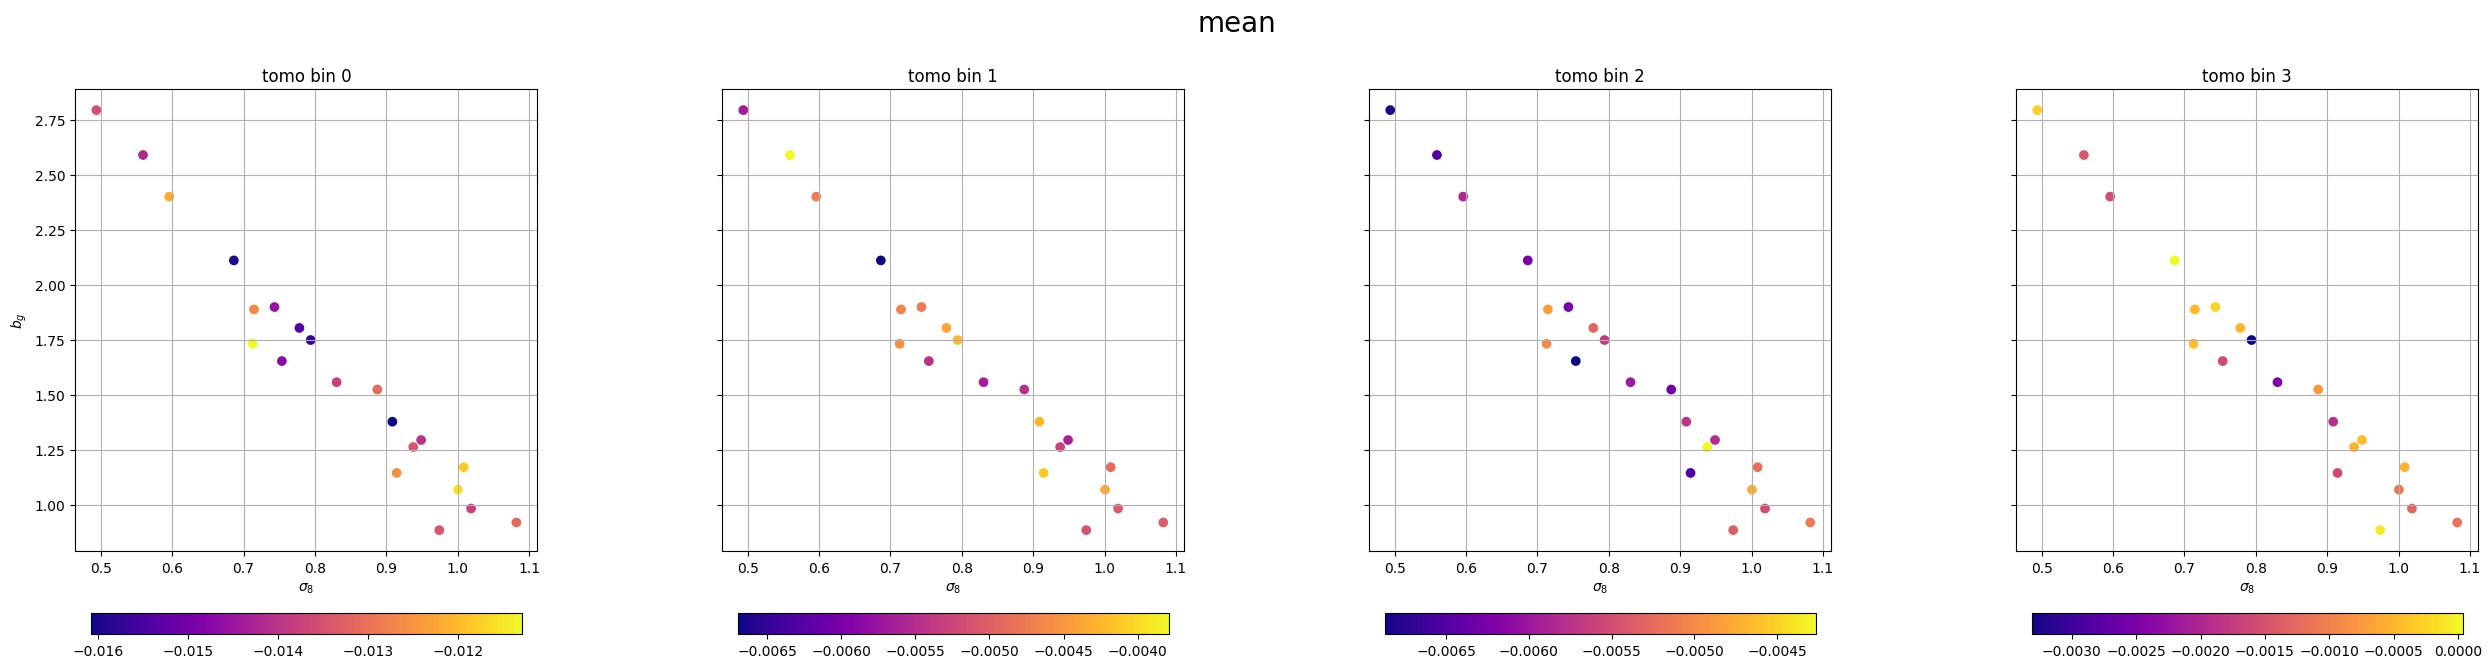

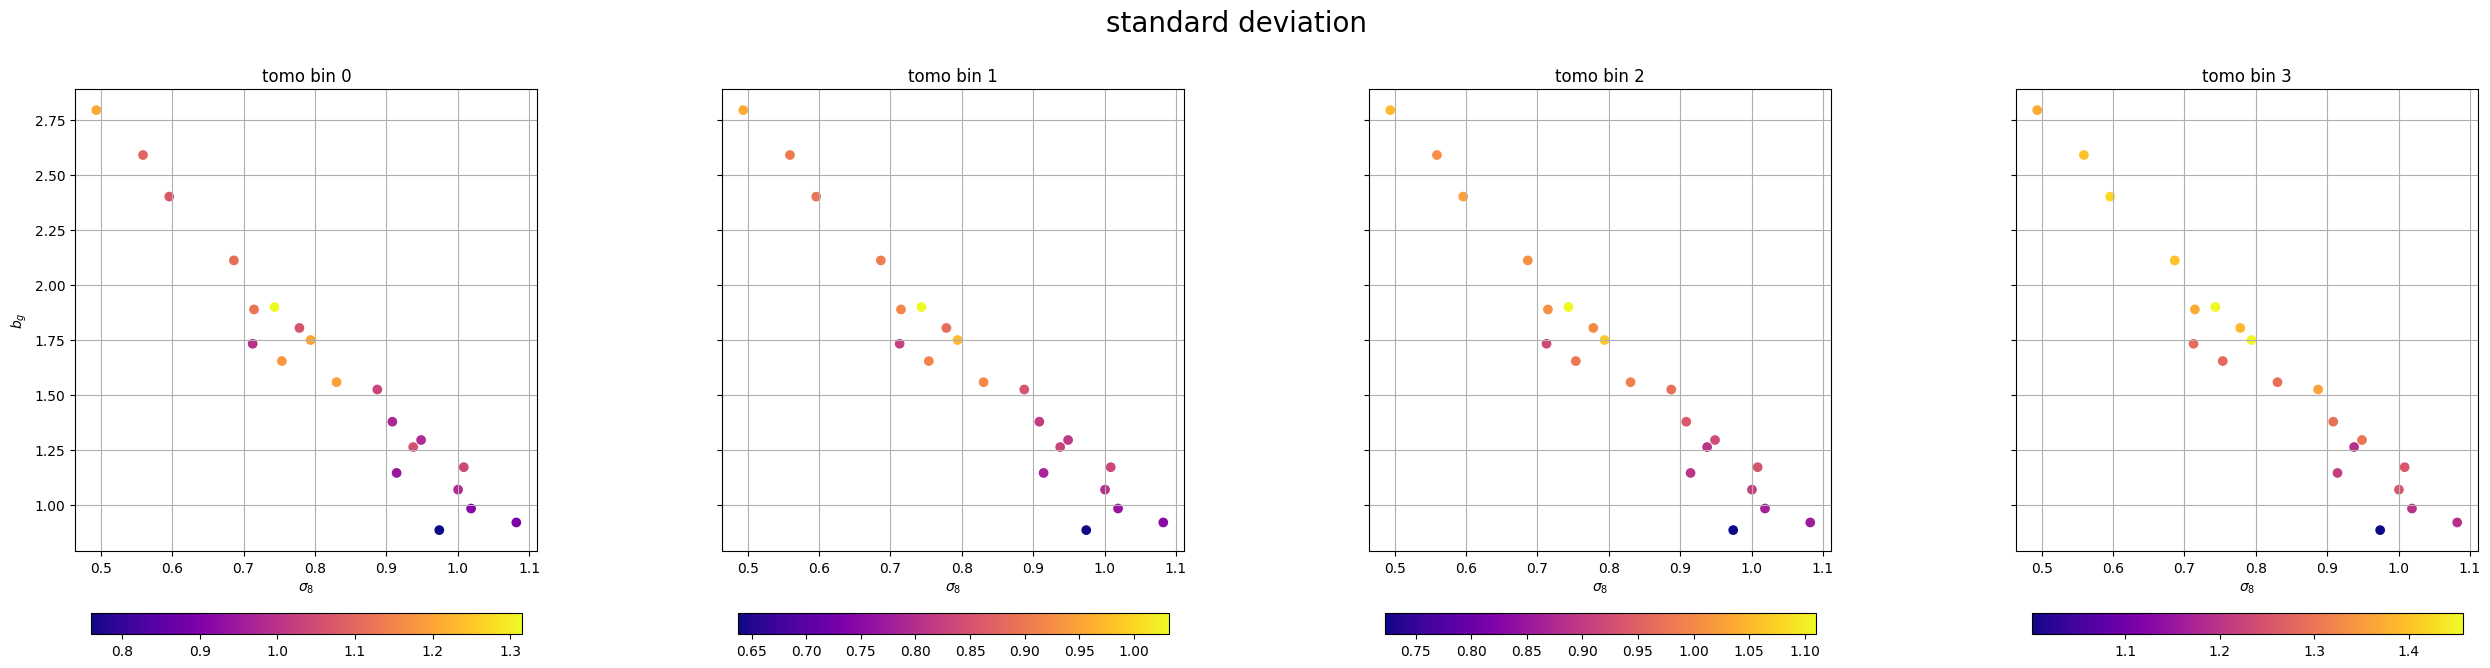

In [42]:
pix_stats = []

pix_stats.append(np.mean(data_vectors, axis=(1,2)))
pix_stats.append(np.std(data_vectors, axis=(1,2)))
# pix_stats.append(skew(data_vectors, axis=(1,2)))
# pix_stats.append(kurtosis(data_vectors, axis=(1,2)))

labels = ["mean", "standard deviation", "skewness", "kurtosis"]

s8 = cosmos[:,1]
bg = cosmos[:,8]

for pix_stat, label in zip(pix_stats, labels):
    fig, ax = plt.subplots(n_rows=2, ncols=n_tomo, sharex=True, sharey=True, figsize=(8*n_tomo, 8*2))

    for i in range(n_tomo):
        # scatter plot
        im = ax[i].scatter(s8, bg, c=pix_stat[:,i], cmap="plasma")
        
        # cosmetics
        ax[i].set_box_aspect(1)
        ax[i].grid(True)
        ax[i].set(xlabel=r"$\sigma_8$", title=f"tomo bin {i}")
        fig.colorbar(im, ax=ax[i], orientation="horizontal", shrink=0.8, pad=0.1)
        
        if i == 0:
            ax[i].set(ylabel=r"$b_g$")
    
    fig.suptitle(label, fontsize=20)
    
    fig.savefig(f"scatter_{label}.png", bbox_inches="tight", dpi=100)

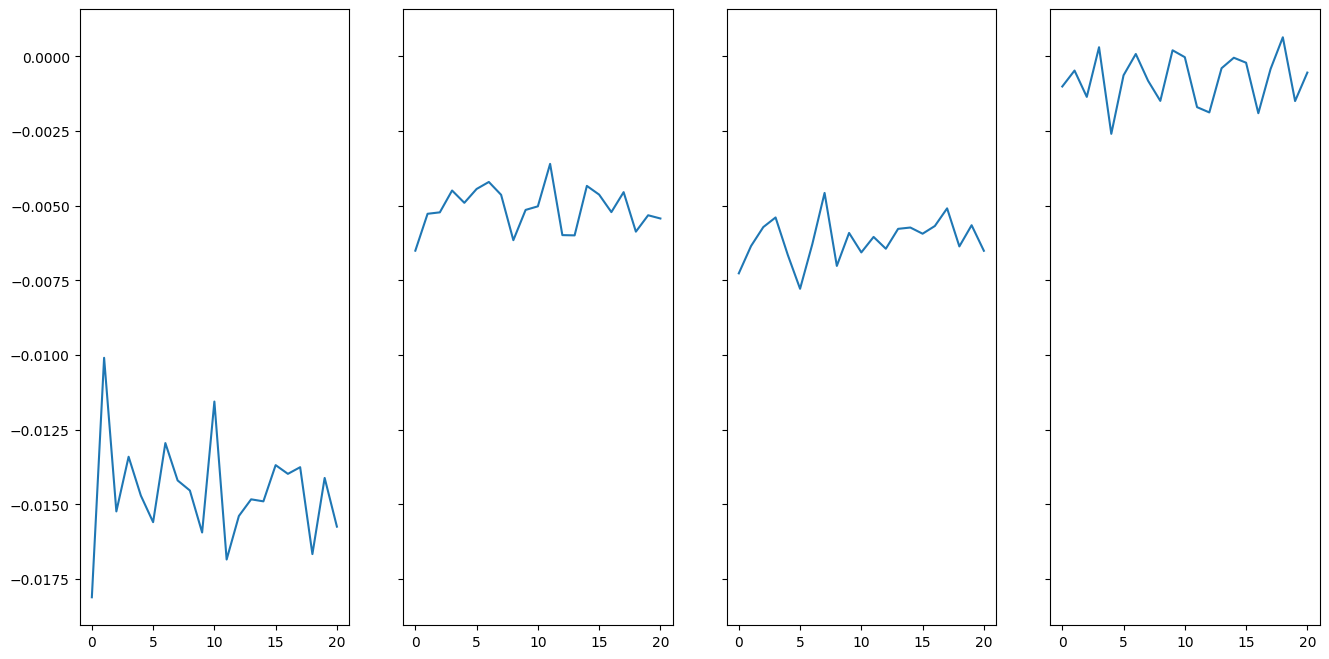

In [50]:
mean_gals = np.mean(data_vectors, axis=(1,2))

fig, ax = plt.subplots(ncols=n_tomo, sharex=True, sharey=True, figsize=(4*n_tomo, 8))

for i in range(n_tomo):
    ax[i].plot(mean_gals[:,i])

100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


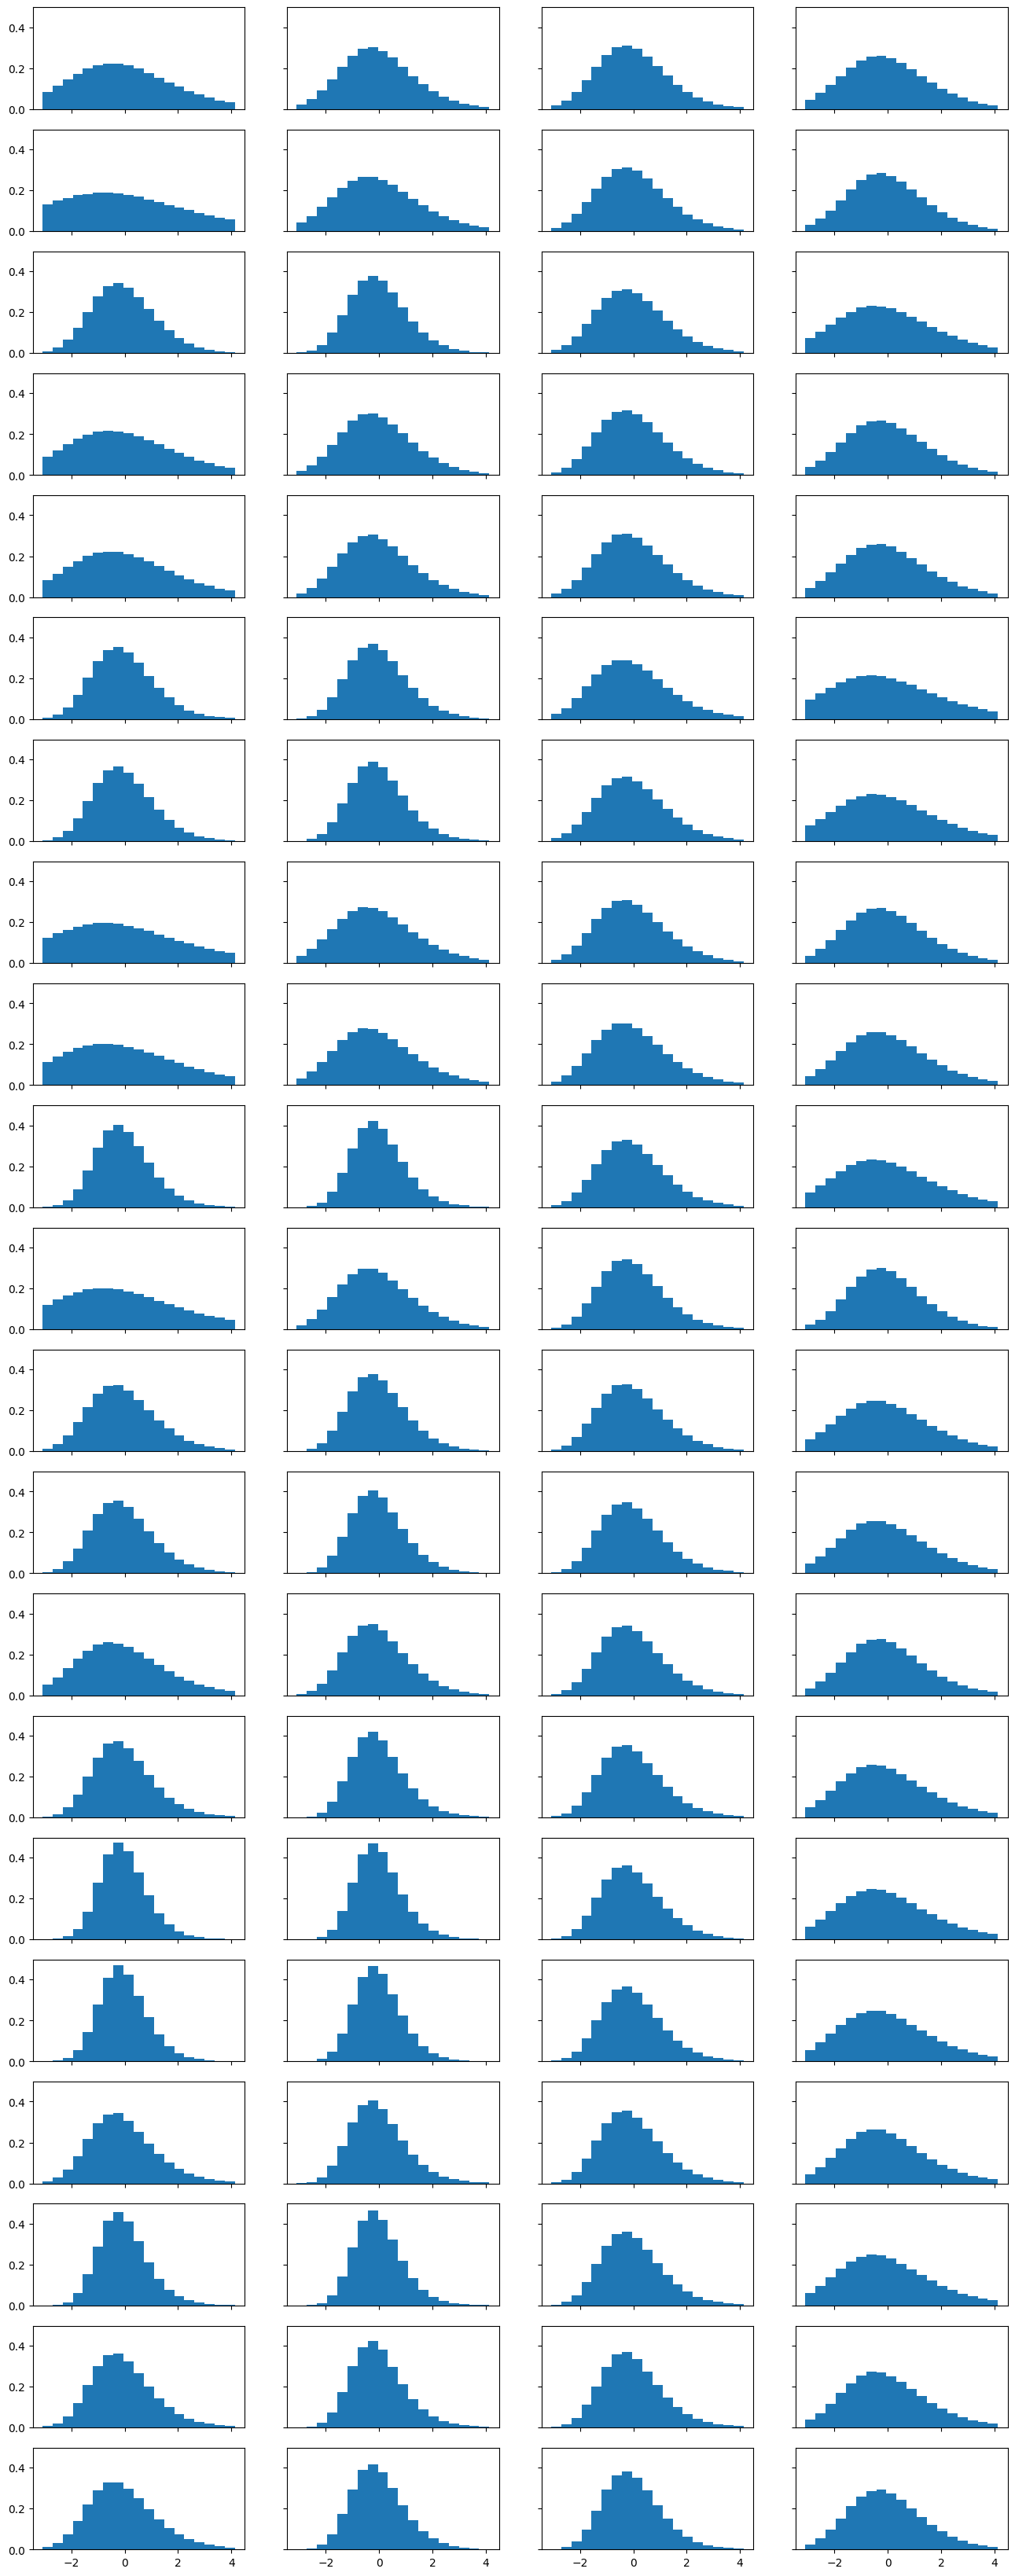

In [34]:
min_gals = np.quantile(data_vectors, 0.01)
max_gals = np.quantile(data_vectors, 0.99)
bins = np.linspace(min_gals, max_gals, 20)

fig, ax = plt.subplots(nrows=n_cosmos, ncols=n_tomo, sharex=True, sharey=True, figsize=(4*n_tomo, 2*n_cosmos))

for i in tqdm(range(n_cosmos)):
    for j in range(n_tomo):
        current_pix = data_vectors[i,:,:,j].ravel()
        
        # remove the padding
        current_pix = current_pix[current_pix != 0]
        
        ax[i,j].hist(current_pix, bins=bins, density=True)

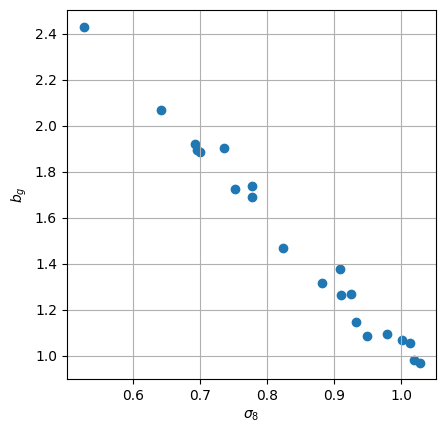

In [11]:
s8 = cosmos[:,0,1]
bg = cosmos[:,0,8]

fig, ax = plt.subplots()
ax.scatter(s8, bg)
ax.set_box_aspect(1)
ax.grid(True)
ax.set(xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
fig.savefig("./s8_bg_degeneracy_points.png", bbox_inches="tight", dpi=300)

In [12]:
i_example = 0
square_pix = 500
reso = 1

gnoms = np.zeros((n_cosmos, n_tomo, 500, 500))

for i in range(n_cosmos):
    for j in range(n_tomo):
        dv_map = data_vectors[i,i_example,:,j]
        # same mask as in the forward model
        # dv_map = np.ma.masked_where(grid_pipe.masks_maglim[:,0]==0, dv_map)

        hp_map = np.zeros(n_pix)
        hp_map[data_vec_pix] = dv_map
        
        gnoms[i,j] = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=square_pix, ysize=square_pix, return_projected_map=True, no_plot=True)

gnoms = np.ma.masked_where(gnoms==0, gnoms)

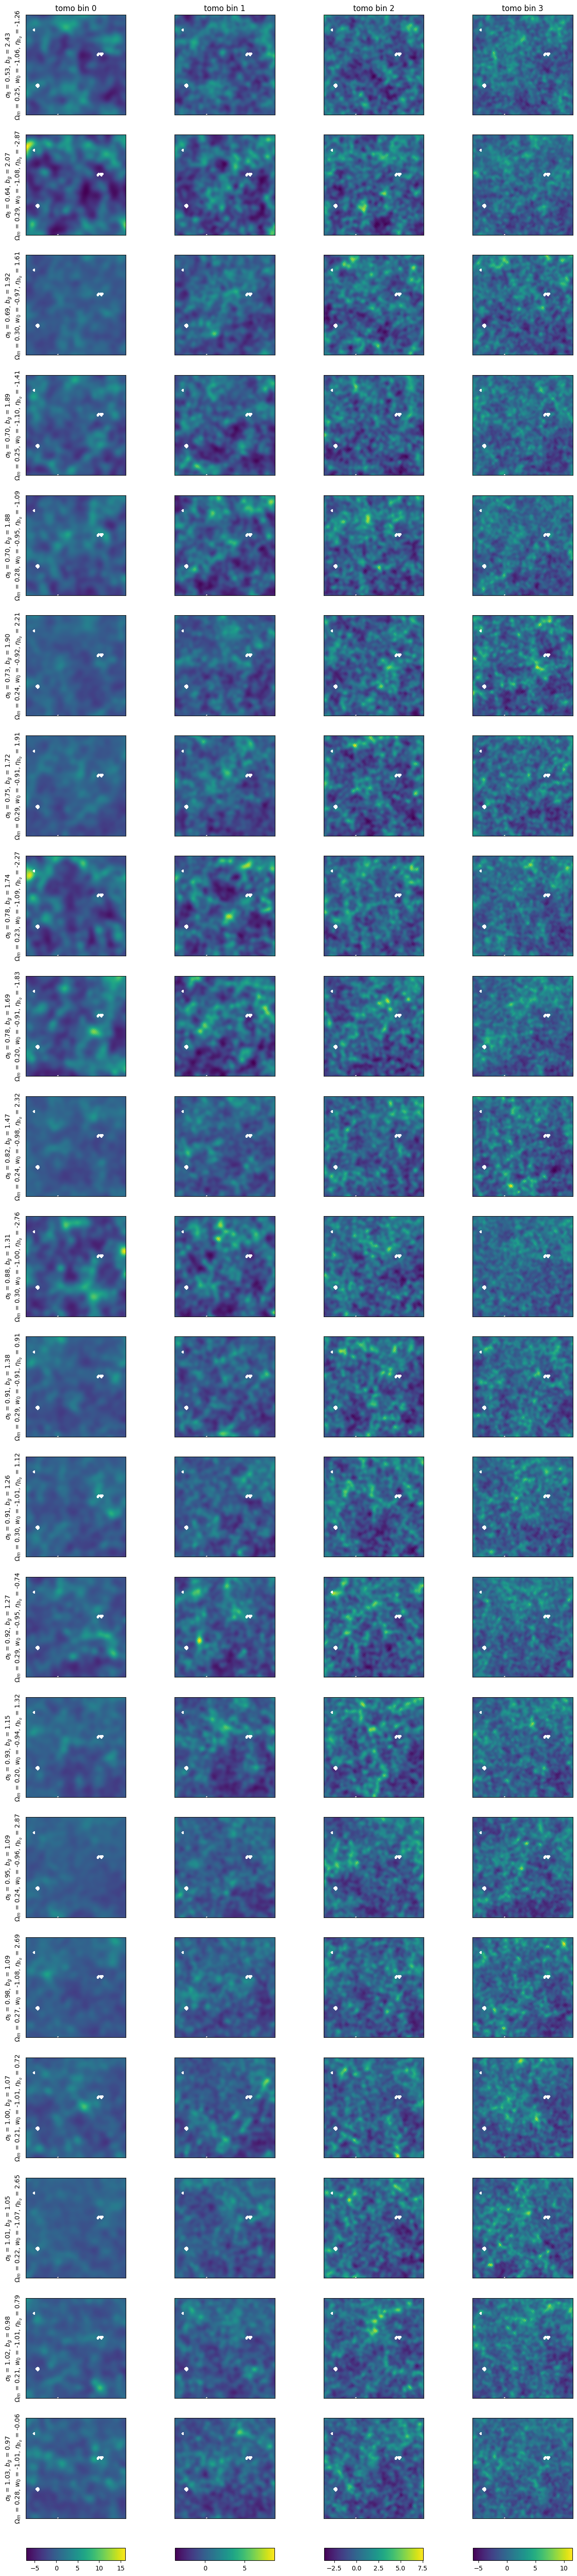

In [13]:
vmin = gnoms.min(axis=(0,2,3))
vmax = gnoms.max(axis=(0,2,3))

# highlight values that are equal to zero
cmap = matplotlib.cm.get_cmap('plasma')
cmap.set_under('red')

fig, ax = plt.subplots(nrows=n_cosmos, ncols=n_tomo, figsize=(n_tomo*4, n_cosmos*4), sharex=True, sharey=True)

for i in range(n_cosmos):
    for j in range(n_tomo):
        im = ax[i,j].imshow(gnoms[i,j], vmin=vmin[j], vmax=vmax[j], cmap=cmap)
        
        # cosmetics
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        if i==0:
            ax[i,j].set(title=f"tomo bin {j}")
        
        if i==n_cosmos-1:
            fig.colorbar(im, ax=ax[:,j], orientation="horizontal", shrink=0.8, aspect=8, pad=0.01, location="bottom")
            
        if j==0:
            ax[i,j].set(ylabel=r"$\sigma_8$ = " + f"{cosmos[i,0,1]:.2f}, " + r"$b_g$ = " + f"{cosmos[i,0,8]:.2f}\n" r"$\Omega_m$ = " + f"{cosmos[i,0,0]:.2f}, " + r"$w_0$ = " + f"{cosmos[i,0,5]:.2f}, " + r"$\eta_{b_g}$ = " + f"{cosmos[i,0,9]:.2f}")

fig.savefig("./s8_bg_degeneracy_data.png", bbox_inches="tight", dpi=300)